# functions

In [1]:
import numpy as np
import pandas as pd
from scipy import interpolate

import xarray as xr
import dask.array as da
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches # for creating legend
import matplotlib.dates as mdates # converts datetime64 to datetime

import cartopy
import cartopy.crs as ccrs # for plotting
import cartopy.feature as cfeature # for map features
from cartopy.util import add_cyclic_point # for wrapping map fully - avoiding white line on 0 deg
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import matplotlib.dates as mdates # converts datetime64 to datetime
import matplotlib.gridspec as gridspec # to create grid-shaped combos of axes
from mpl_toolkits import mplot3d # 3d plotting tool
import cmocean # for nice oceanography colour pallettes

#import argopy
#from argopy import DataFetcher as ArgoDataFetcher # to load Argo ds directly

import os # for finding files

import gsw # for conversion functions

from tqdm.notebook import tqdm_notebook as tqdm
import glob # for downloading data
import sys # for path to functions

import seaborn as sns

sns.set(#font='Franklin Gothic Book',
        rc={
         'axes.axisbelow': False,
         'axes.edgecolor': 'Black',
         'axes.facecolor': 'w', 
                            # '#aeaeae',
         'axes.grid': False,
         'axes.labelcolor': 'k',
         'axes.spines.right': True,
         'axes.spines.top': True,
         'figure.facecolor': 'white',
         'lines.solid_capstyle': 'round',
         'patch.edgecolor': 'k',
         'patch.force_edgecolor': True,
         'text.color': 'k',
         'xtick.bottom': True,
         'xtick.color': 'k',
         'xtick.direction': 'out',
         'xtick.top': False,
         'ytick.color': 'k',
         'ytick.direction': 'out',
         'ytick.left': True,
         'ytick.right': False},
         font_scale=1)
mpl.rcParams["figure.titlesize"] = 30
mpl.rcParams["axes.titlesize"] = 25
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams["font.size"] = 12
mpl.rcParams["xtick.labelsize"] = 15
mpl.rcParams["ytick.labelsize"] = 15
mpl.rcParams["ytick.labelright"] = False

from warnings import filterwarnings as fw
fw('ignore')

# import my own funcs
import sys
sys.path.append('/home/theospira/notebooks/projects/01-WW_climatology/functions')
from plot_formatting import circular_boundary,plot_nice_box
from inspection_funcs import boxplot

import importlib
#importlib.reload(sys.modules['inspection_plot'])

In [2]:
sys.path.append('/home/theospira/notebooks/projects/03-WW-timeseries/funcs')
from plotting import *
from computations import calc_mean_var
from import_data import *

In [3]:
importlib.reload(sys.modules['import_data'])
from import_data import *

# sea ice!!!

### save as new ds

In [3]:
si =[]
for n in glob.glob('/home/theospira/notebooks/projects/WW-timeseries/data/sea-ice/monthly-NSIDC-G02202/*.nc'):
        si += xr.open_dataset(n),

In [4]:
si = xr.concat(si,dim='tdim') 

In [5]:
si = si.sortby('time')

In [6]:
si

<xarray.Dataset>
Dimensions:                           (tdim: 240, y: 332, x: 316)
Coordinates:
    time                              (tdim) datetime64[ns] 2004-01-01 ... 20...
    xgrid                             (x) float32 -3.938e+06 ... 3.938e+06
    ygrid                             (y) float32 4.338e+06 ... -3.938e+06
Dimensions without coordinates: tdim, y, x
Data variables:
    cdr_seaice_conc_monthly           (tdim, y, x) float32 0.0 0.0 ... 0.0 0.0
    nsidc_bt_seaice_conc_monthly      (tdim, y, x) float32 0.0 0.0 ... 0.0 0.0
    nsidc_nt_seaice_conc_monthly      (tdim, y, x) float32 0.0 0.0 ... 0.0 0.0
    projection                        (tdim) |S1 b'' b'' b'' b'' ... b'' b'' b''
    qa_of_cdr_seaice_conc_monthly     (tdim, y, x) float32 16.0 16.0 ... 16.0
    stdev_of_cdr_seaice_conc_monthly  (tdim, y, x) float32 0.0 0.0 ... 0.0 0.0
Attributes: (12/42)
    Conventions:               CF-1.6, ACDD-1.3
    title:                     NOAA/NSIDC Climate Data Record of Passive Micr...
    comment:                   none
    program:                   NOAA Climate Data Record Program
    cdr_variable:              cdr_seaice_conc_monthly
    metadata_link:             https://nsidc.org/data/g02202/versions/4/
    ...                        ...
    platform:                  DMSP 5D-3/F17 > Defense Meteorological Satelli...
    sensor:                    SSMI/S > Special Sensor Microwave Imager/Sounder
    date_created:              2021-06-22T16:57:32Z
    time_coverage_start:       2016-12-01T00:00:00Z
    time_coverage_end:         2016-12-31T23:59:59Z
    references:                Comiso, J. C., and F. Nishio. 2008. Trends in ...

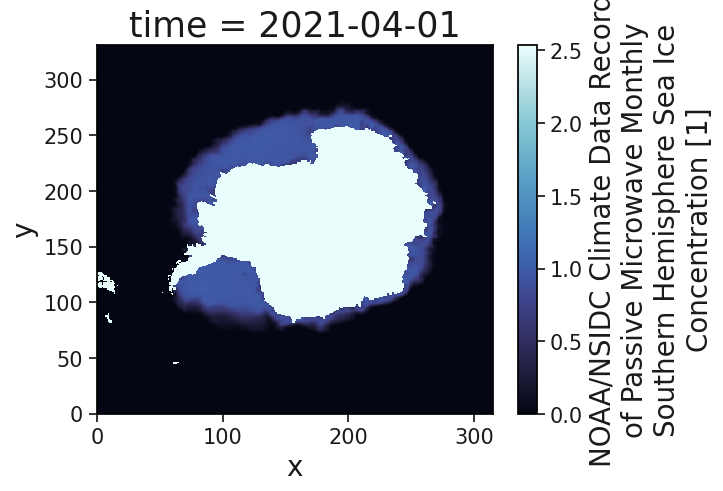

In [35]:
si.isel(tdim=207).cdr_seaice_conc_monthly.plot(x='x',cmap='cmo.ice')

In [38]:
si.time.max()

<xarray.DataArray 'time' ()>
array('2023-12-01T00:00:00.000000000', dtype='datetime64[ns]')

In [39]:
si.to_netcdf('/home/theospira/notebooks/projects/WW-timeseries/data/sea-ice/sea-ice-2004-2023.nc')

## open dataset

use NSIDC polar stereo conversion functions: https://github.com/nsidc/polarstereo-lonlat-convert-py/tree/main

In [3]:
# import NSIDC polar stereo functions
sys.path.append('/home/theospira/notebooks/projects/WW-timeseries/funcs/polarstereo-lonlat-convert')

In [4]:
si = xr.open_dataset('/home/theospira/notebooks/projects/WW-timeseries/data/sea-ice/sea-ice-2004-2023.nc')

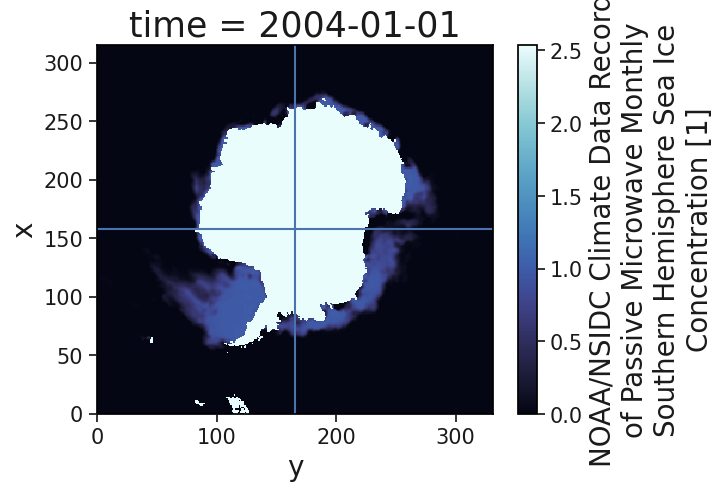

In [5]:
si.cdr_seaice_conc_monthly[0].plot(x='y',cmap='cmo.ice')
plt.axhline(si.x.max().data/2)
plt.axvline(si.y.max().data/2)

In [6]:
from polar_convert import *

lon = np.ndarray(si.cdr_seaice_conc_monthly[0].shape)*np.nan
lat = np.ndarray(si.cdr_seaice_conc_monthly[0].shape)*np.nan

for j in tqdm(range(si.x.size)): # represents lat data
    for i in range(si.y.size):   # represents lon data
        ln,lt = polar_ij_to_lonlat(si.x.data[j]+1,si.y.data[i]+1, 25, 'south')
        lon[i,j] = ln
        lat[i,j] = lt

  0%|          | 0/316 [00:00<?, ?it/s]

In [7]:
si['lat'] = xr.DataArray(lat,dims=si.cdr_seaice_conc_monthly[0].dims)
si['lon'] = xr.DataArray(lon,dims=si.cdr_seaice_conc_monthly[0].dims)

## some investigatory figures

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110

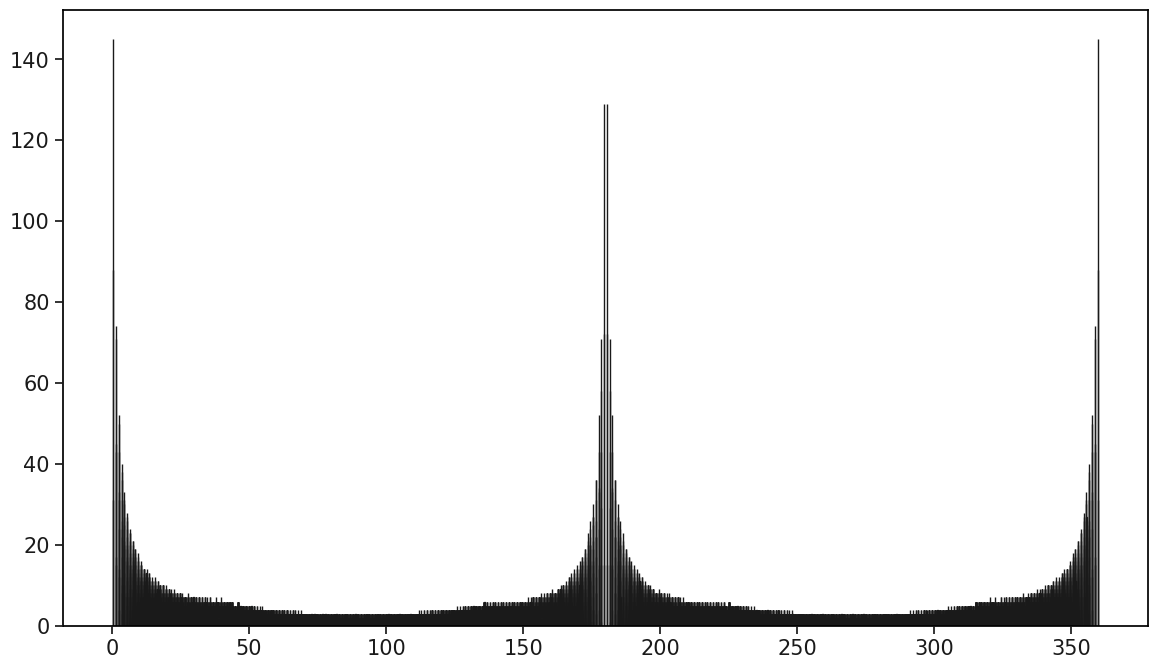

In [59]:
plt.figure(figsize=(14,8))
plt.hist(lon,bins=np.arange(0,361,1))

(array([[ 0.,  0.,  0., ..., 14., 12.,  7.],
        [ 0.,  0.,  0., ..., 14., 11.,  7.],
        [ 0.,  0.,  0., ..., 14., 10.,  7.],
        ...,
        [ 0.,  0.,  0., ..., 14., 10.,  7.],
        [ 0.,  0.,  0., ..., 14., 11.,  7.],
        [ 0.,  0.,  0., ..., 14., 12.,  7.]]),
 array([-90., -89., -88., -87., -86., -85., -84., -83., -82., -81., -80.,
        -79., -78., -77., -76., -75., -74., -73., -72., -71., -70., -69.,
        -68., -67., -66., -65., -64., -63., -62., -61., -60., -59., -58.,
        -57., -56., -55., -54., -53., -52., -51., -50., -49., -48., -47.,
        -46., -45., -44., -43., -42., -41., -40.]),
 <a list of 316 BarContainer objects>)

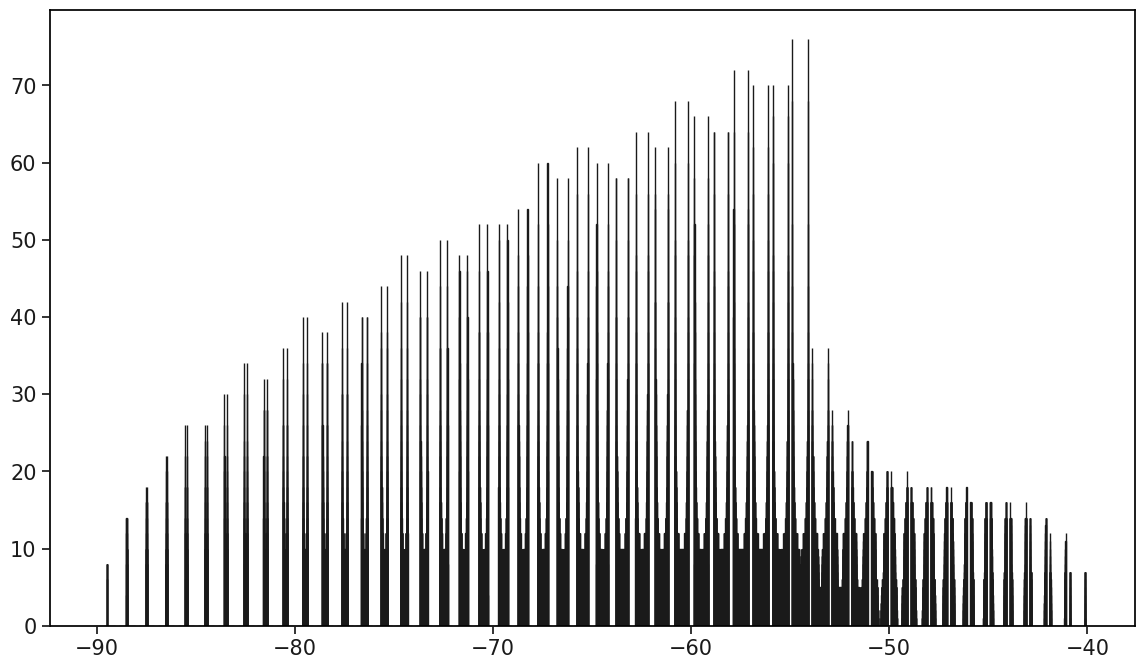

In [85]:
plt.figure(figsize=(14,8))
plt.hist(lat,bins=np.arange(-90,-39,1))

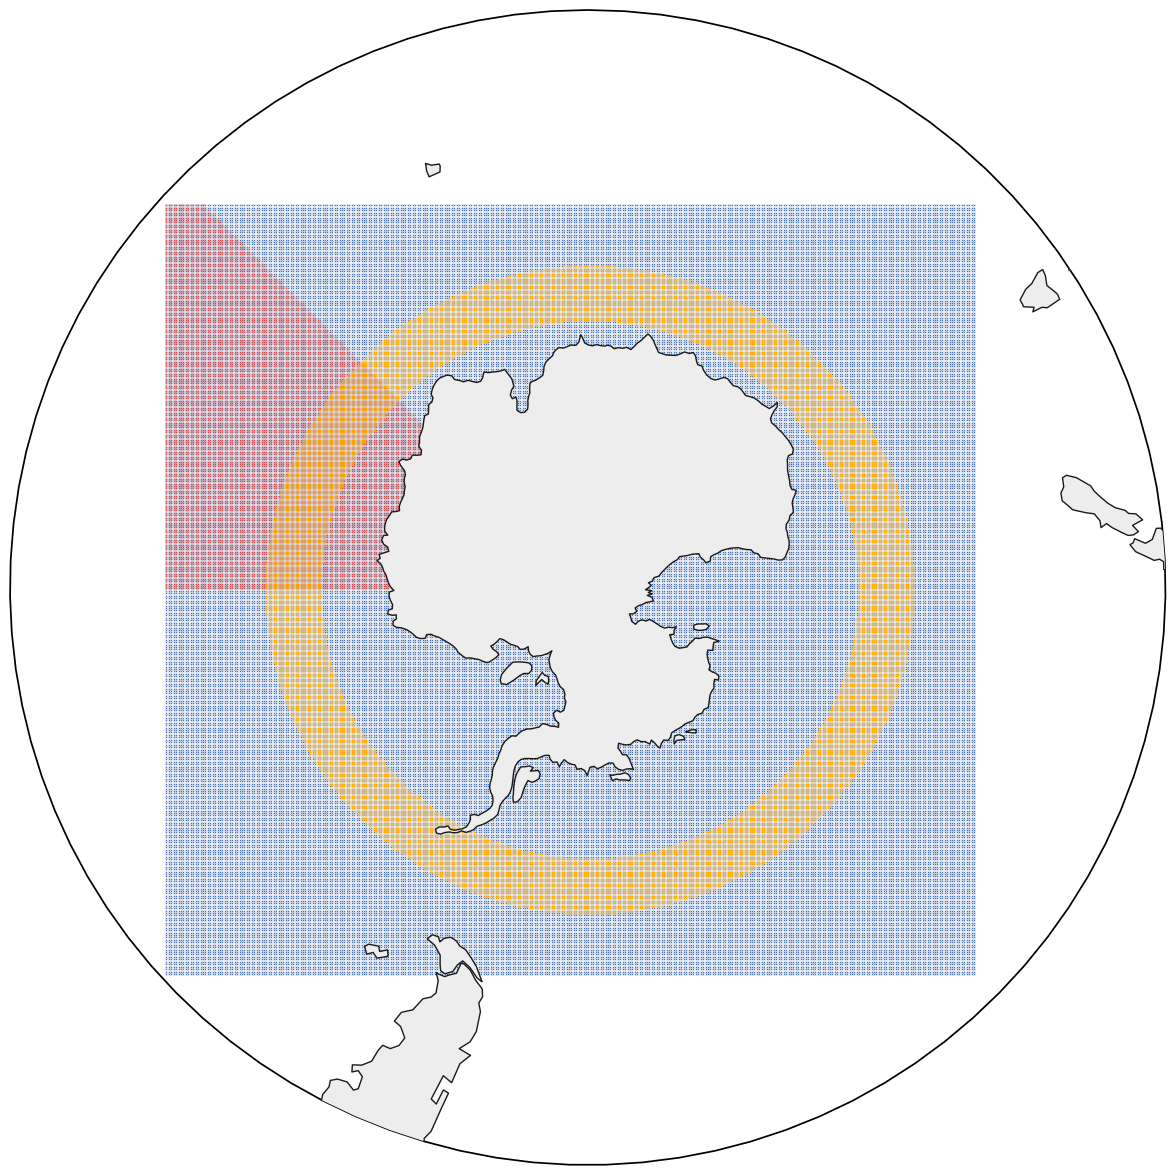

In [81]:
from mycolorpy import colorlist as mcp
#c=mcp.gen_color(cmap="Accent",n=len(zones))

from plot_formatting import plot_nice_box
# lon_range,sector = lon_boundaries()

extent = [0,360,-90,-38.75]
crs = ccrs.PlateCarree()

plt.figure(figsize=(15,15))
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=90))
circular_boundary(ax)

ax.set_extent(extent, crs=crs)
ax.add_feature(cfeature.LAND, zorder=9, #edgecolor='lightgrey', 
               facecolor = "#ededed",
              )
ax.coastlines(zorder=10,color="k") # shows contin

ax.scatter(lon,lat,s=0.1,marker='x',transform=crs)
idx = np.logical_and(lon>0,lon<45)
ax.scatter(lon[idx],lat[idx],s=0.1,marker='x',transform=crs,c='r')

idx = np.logical_and(lat<-60,lat>-65)
ax.scatter(lon[idx],lat[idx],s=0.1,marker='x',transform=crs,c='orange')

#ds.adt.mean('time',skipna=1).plot.contour(x='lon',levels=np.arange(-1.5,1.1,0.175),ax=ax,transform=crs,colors='darkgrey',linestyles='-')

## grid to lat-lon space

In [9]:
# remove on land and coastal sea ice
sic = si.where(np.logical_and(si.nsidc_nt_seaice_conc_monthly != 2.54,
                              si.nsidc_nt_seaice_conc_monthly != 2.53))#.cdr_seaice_conc_monthly

In [15]:
# define time bins
t_bins = pd.date_range('2003-12-31', '2024-01-01', freq='1M')

# define lon min and max resp
gs = 1
lon_min = 0
lon_max = 360
lon = np.arange(lon_min,lon_max+gs,gs)
lon_labels = np.arange(0,lon_max-lon_min,gs)

lat_min = -80
lat_max = -40
lat = np.arange(lat_min,lat_max+gs,gs)
lat_labels = range(0,lat_max-lat_min,gs)

# group by time bines
var = sic[['cdr_seaice_conc_monthly','lat','lon']].groupby_bins(sic.time, bins=t_bins, labels=np.arange(len(t_bins)-1))

# group into lon bins
arr = np.ndarray([t_bins.size-1,360,40])*np.nan
for t,gr_t in tqdm(var):
    var1 = gr_t.groupby_bins(gr_t.lon,lon,labels=lon_labels,restore_coord_dims=True)
    
    # now group into lat bins for each lon group:
    for ln,gr_ln in var1:
        var2 = gr_ln.groupby_bins(gr_ln.lat,lat,labels=lat_labels,restore_coord_dims=True)
        
        # now take the mode!
        for lt,gr_lt in var2:
            arr[t,ln,lt] = gr_lt.cdr_seaice_conc_monthly.median(skipna=True).data

  0%|          | 0/240 [00:00<?, ?it/s]

In [16]:
np.save('/home/theospira/notebooks/projects/WW-timeseries/data/sea-ice/gridded-sea-ice-1deg.npy',arr)

In [ ]:
arr = np.load('/home/theospira/notebooks/projects/WW-timeseries/data/sea-ice/gridded-sea-ice-1deg.npy')

x    = 1 
time = pd.date_range('2004-01-01', '2024-01-01', freq='1M')
lat  = np.arange(-79,-40+x,x)
lon  = np.arange(-180,180,x)

ds = xr.Dataset(
            data_vars = dict(sic = (['time','lon','lat'], arr),),
            coords   = dict(
                            time    = (['time'], time),
                            lon     = (['lon'], lon),
                            lat     = (['lat'], lat),
                            ),)

In [40]:
ds = ds.sel(lat=slice(-80,-50))

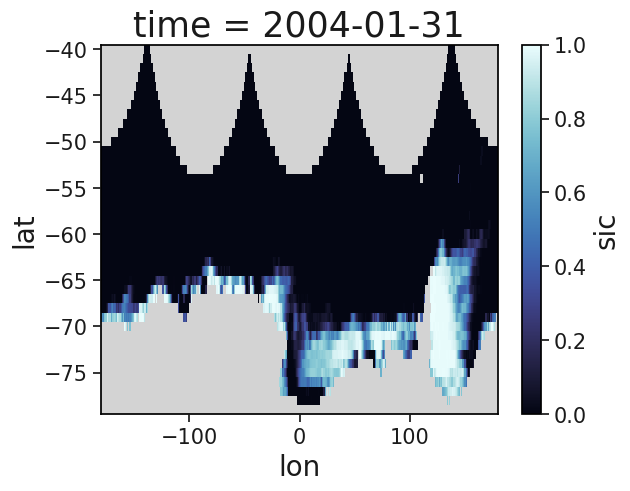

In [43]:
ds.sic[0].plot(x='lon',cmap='cmo.ice')
plt.gca().set_facecolor('lightgrey')